# Demo 1: The Basic Setup of Our Evolutionary Algorithm

In [1]:
%load_ext autoreload
%autoreload 2
from EVO_BASE import LogisticRegression, EvolutionOptimizer
import torch
import numpy as np
import time
import random
import matplotlib.pyplot as plt

### The Big Idea:

We establish a collection of weight vectors (possible solutions of w) as a population. Each "individual" in the population is thus an individual weight vector. Each "generation", we perform the following procedure on the population.

1. Select the "best" individuals based on some selection criteria (In our case, the loss of the weight vector)
2. Combine these selected individuals into "offspring" (To become a new generation of weight vectors)
3. Mutate some part of the population/individuals to add evolutionary variety
4. Repeat until a weight vector has been found which minimizes loss

### Here is a look at how the Class is set up:

```python
"""
First, we set up the class instance. Each instance of the EvolutionOptimizer has a model attribute - the model it inherits/passed through the constructor which we are trying to train on. It also has a mutation "rate" value which determines how much/how often random changes are introduced to weight vectors. This is initialized to 0.1. Then, we have population_size, which is how many individuals - i.e. possible solution weight vectors - are in our instance.
"""
def __init__(self, model):
    self.model = model
    self.mutation = 0.1  
    self.population_size = 100

```python
"""
This function allows us to adjust how often we introduce mutations - random changes - to the population.
"""
def set_mutation(self, mutation):
    self.mutation = mutation

```python
"""
This function allows us to adjust how many individual weight vectors are in our population.
"""
def set_population_size(self, population_size):
    self.population_size = population_size

```python
"""
This is the main function in our class, which performs one generation of evolution on our population.
"""
def step(self, X, y):
    # We first check if the population even exists yet 
    # (i.e. if individual weight vectors exist in our population)
    # If not, we create a set of random weight vectors to get started
    if self.model.population == []:
        self.model.population = [torch.rand(X.size(1)) for _ in range(self.population_size)]

    # We sort all "individuals" by how well they perform on our evolutionary "test"
    # In our case, we rank them by loss
    # (i.e. how much loss a given weight vector produces on our training data set X)
    # Lower loss is "better" in our current setup
    population = sorted(population, key=lambda w: self.model.loss(X, y, w))
    
    # Based on this sorted population, we perform the "best" half - the half of
    # weight vectors which has the lowest loss - and make them the basis of the new population
    population = population[:self.population_size // 2]

    # Create a new population array
    new_population = []

    # Now, for each individual in the population, we do the following:
    # Note, that while we removed half the population already, the "population_size"
    # attribute has not been updated. So, in this case, we are executing this loop
    # 100 times
    for _ in range(self.population_size):
        # We pick two "parents" from the population randomly
        parent1 = random.choice(population)
        parent2 = random.choice(population)

        # We create a new "child" weight vector by mixing the elements of the parents
        # This is meant to mimic genetic crossover

        # 1. Create a random binary mask tensor the same shape as parent1
        # Each element of this tensor of values between 0 and 1
        # Compare to 0.5 to turn value to False or True
        mask = torch.rand_like(parent1) < 0.5

        # 2. Build a child tensor using the binary mask
        # if mask[i] is True, then child[i] = parent1[i]
        # if mask[i] is False, then child[i] = parent2[i]
        # So, on average, the child will inherit half its weights from each parent
        child = torch.where(mask, parent1, parent2)

        # Now, we introduce mutation into the child weight vector

        # 1. Create a random mask that determines which genes (weights) in the child will be mutated
        # < self.mutation compares each value to the mutation rate, and converts to True or False
        # The result tensor is boolean, where True means we will mutate that weight
        # and False means we will not mutate
        mutation_mask = torch.rand_like(child) < self.mutation

        # 2. This generates random noise to be added to mutated geans
        # torch.normal gets values from a normal distribution
        # mean = 0.0 means the average mutation is 0
        # std = 0.1 will keep most mutations small (determines standard deviation)
        mutation_values = torch.normal(mean=0.0, std=0.1, size=child.size())

        # 3. Apply the mutation where our mutation_mask is True
        # if mutation_mask[i] is True, then child[i] = child[i] + mutation_values[i]
        # if mutation_mask[i] is False, then child[i] remains unchanged
        child = torch.where(mutation_mask, child + mutation_values, child)

        # Add the child to the new population
        new_population.append(child)

    
    # Now, we replace the old population with the new one we have just created
    self.model.population = new_population

    # Set the model weight to the individual with the lowest loss
    best = min(new_population, key=lambda w: self.model.loss(X, y, w))
    self.model.w = best


So, with that, we have the complete step function for our evolutionary model:

```python
def step(self, X, y):
        if self.model.population == []:
            self.model.population = [torch.rand(X.size(1)) for _ in range(self.population_size)]

        population = self.model.population
        population = sorted(population, key=lambda w: self.model.loss(X, y, w))
        population = population[:self.population_size // 2]  # Keep the best half

        new_population = []

        for _ in range(self.population_size): 
            parent1 = random.choice(population)
            parent2 = random.choice(population)

            # Inherit half from each parent
            mask = torch.rand_like(parent1) < 0.5
            child = torch.where(mask, parent1, parent2)

            mutation_mask = torch.rand_like(child) < self.mutation
            mutation_values = torch.normal(mean=0.0, std=0.1, size=child.size())
            child = torch.where(mutation_mask, child + mutation_values, child)

            new_population.append(child)

        # Update population and set model weights to best
        self.model.population = new_population
        best = min(new_population, key=lambda w: self.model.loss(X, y, w))
        self.model.w = best

In [5]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

In [6]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    return (y_pred == y).float().mean().item()

Time taken:  2.197161912918091


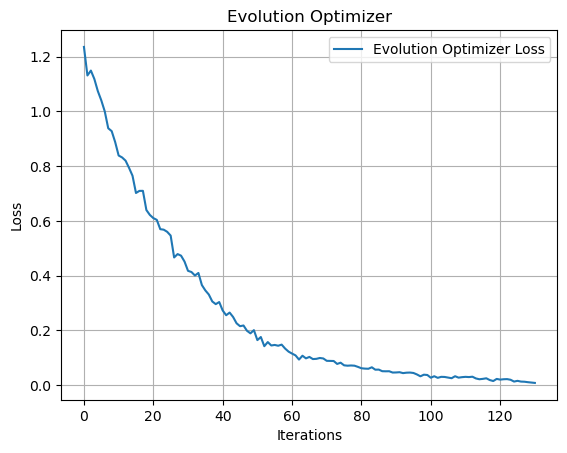

In [7]:
X, y = classification_data(p_dims=200, noise=0.8, n_points=1000)
LR = LogisticRegression()
opt = EvolutionOptimizer(LR)
opt.set_mutation(0.5)
opt.set_population_size(100)
losses = []
start = time.time()
while accuracy(LR, X, y) < 1:
    opt.step(X, y)
    losses.append(LR.loss(X, y).item())
print("Time taken: ", time.time() - start)
plt.plot(losses, label="Evolution Optimizer Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer")
plt.legend()
plt.grid(True)
plt.show()